In [1]:
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt

from IPython.display import display, Latex
plt.style.use('bmh')

# Metropolis-Hastings: A Simple Example

Suppose the parameter space is discrete and $\theta$ can only take two
values: $\tau_1$ and $\tau_2$. The posterior distribution then simplifies
to two probabilities which we denote as $\pi_l = \mathbb{P}\{ \theta=\tau_l|Y\}$, $l=1,2$.

The proposal distribution in Algorithm 3
can be represented as a two-stage Markov process with transition
matrix
$$
Q = \left[ \begin{array}{cc} q_{11} & q_{12} \\ q_{21} & q_{22} \end{array} \right],
$$
where $q_{lk}$ is the probability of drawing $\vartheta = \tau_k$ conditional
on $\theta^{i-1} = \tau_l$. For illustrative purposes, we will assume that
$$
q_{11} = q_{22} = q, \quad q_{12}=q_{21}=1-q
$$
and that the posterior distribution has the property
$$
\pi_2 > \pi_1.
$$

## Analytical Results
To make our example concrete, we'll set 
$\pi_1=0.2$ 
and 
$\left[\tau_1,\tau_2\right] = [0,1]$. 

In [2]:
from scipy.stats import rv_discrete

pi1 = 0.2
thet1, thet2 = 0, 1 

tau = rv_discrete(values=[(thet1, thet2), (pi1, 1-pi1)])

Given our assumptions above, we can also specify the proposal distribution
as a conditional binomial distribution--one binomial for each
$\theta^{i-1} = \tau_1$ and $\theta^{i-1} = \tau_2$.  We construct
both proposal distributions using the python dictionary below.

In [3]:
def prop(q):
    """
    Returns a dictionary with keys tau_1 and tau_2
    and values discrete RV with probabilities determined 
    by $q$ as in the matrix above. 
    """
    proposal = {}     
    
    proposal[tau.xk[0]] = rv_discrete(values=[(tau.xk[0], tau.xk[1]), (q, 1-q)])
    proposal[tau.xk[1]] = rv_discrete(values=[(tau.xk[0], tau.xk[1]), (1-q, q)])

    return proposal

Using this proposal distribution, we can compute $\alpha(\vartheta|\theta)$ the probability of accepting proposal $\vartheta$ given the current value $\theta$.  Below we show $\alpha$ for $q=0.2$.

In [4]:
def alpha(vartheta, theta, q=0.2):
    """
    Computes acceptance probability.
    """
    post_ratio = tau.pmf(vartheta) / tau.pmf(theta) 
    prop_ratio = (prop(q)[vartheta].pmf(theta)
                  / prop(q)[theta].pmf(vartheta))
    return min(post_ratio / prop_ratio, 1)


from itertools import product

for vartheta, theta in product((thet1,thet2),(thet1,thet2)):
    alpha_str = (r'$\alpha(\vartheta=\tau_{}|\theta=\tau_{})={}$'
                 .format(vartheta+1,theta+1,alpha(vartheta,theta)))
    display(Latex(alpha_str))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

If we combine these acceptance probabilities with the appropriate proposal probabilities, we can construct the Markov transition matrix implied by our MH algorithm.  When constructing these probabilities, recall that we can transition from, say, $\tau_1$ to $\tau_1$ both by proposing $\tau_1$ and accepting this draw, or by proposing from $\tau_2$ and rejecting.  

In [6]:

def transition_matrix(q=0.2):
    k11 = ( alpha(thet1,thet1,q=q)*prop(q)[thet1].pmf(thet1) 
           + (1-alpha(thet2,thet1,q=q))*prop(q)[thet1].pmf(thet2))

    k12 = alpha(thet2,thet1,q=q)*prop(q)[thet1].pmf(thet2)
    k21 = alpha(thet1,thet2,q=q)*prop(q)[thet2].pmf(thet1)

    k22 = ( alpha(thet2,thet2,q=q)*prop(q)[thet2].pmf(thet2) + 
           + (1-alpha(thet1,thet2,q=q))*prop(q)[thet2].pmf(thet1))

    return np.array([[k11,k12],[k21,k22]])

K = transition_matrix()
print('K = ', K )

K =  [[0.2 0.8]
 [0.2 0.8]]


The transition matrix has $\pi$ as an invariant distribution.  We can verify this with:

In [8]:
pi_act = np.array([pi1,1-pi1])
print((pi_act == pi_act.dot(K)).all())

False


The transition matrix has two eigenvalues, which we compute below.  If the second eigenvalue is different from one,
the posterior is the unique invariant distribution of the Markov chain.
The persistence of the Markov chain is characterized by this eigenvalue.

In [10]:
eig, eigv = np.linalg.eig(K)
print(eig)

[0. 1.]


The non-unitary eigenvalue is 0 (to machine precision), which means that the chain generates uncorrelated draws.  In general, as we describe in the tex, the markov chain generated by this chain will follow an AR(1), with
an autocorrelation of $$ CORR(\theta^i, \theta^{i-s}) = \left(q -
(1-q)\frac{\pi_1}{1-\pi_1}\right)^s. $$ 
The expression inside the parantheses corresponds to the second (non unit) eigenvalue of the matrix K. 

One can see that different proposal distributions--indexed by $q$--will have very different behavior, as evidenced by their autocorrelation functions, which are plotted below. 

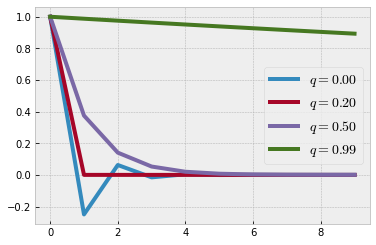

In [11]:
qvec = np.array([0.000001, 0.2, 0.5, 0.99])

for q in qvec:
    K = transition_matrix(q)
    eig, eigv = np.linalg.eig(K)          
    plt.plot(eig[0]**np.arange(10), linewidth=4)

_ = plt.legend([r'$q=0.00$', '$q=0.20$', '$q=0.50$', '$q=0.99$'], fontsize=14, loc='center right')


The persistence of the Markov chain depends on the proposal distribution,
which in our discrete example is characterized by the probability $q$. While in general it is not feasible to tailor the proposal density to
generate serially uncorrelated draws, the goal of MCMC design is to keep the
persistence of the chain as low as possible. As $q$ approaches one,
the autocorrelation of the Markov chain increases and converges to one.
In the limit, if $q=1$, then
$\theta^i=\theta^1$ for all $i$ and the equilibrium distribution of the chain is
no longer unique.

Monte Carlo estimates of functions $h$ will have their variance inflated by this integrated
autocorrelation relative to estimates from IID draws, as can be seen below.

Defining the Monte Carlo estimate
$$
\bar{h}_N = \frac{1}{N} \sum_{i=1}^N h(\theta^i)
$$
we deduce from a central limit theorem for dependent random variables that
$$
\sqrt{N} (\bar{h}_N - \mathbb{E}_\pi[h])
\Longrightarrow N \big(0, \Omega(h) \big),
$$
where $\Omega(h)$ is now the long-run covariance matrix
$$
\Omega(h) = \lim_{L \longrightarrow \infty} \mathbb{V}_\pi[h] \left( 1 + 2 \sum_{l=1}^L \frac{L-l}{L} \left( q - (1-q)\frac{\pi_1}{1-\pi_1} \right)^l \right).
$$
In turn, the asymptotic inefficiency factor is given by 

$$
\mbox{InEff}_\infty = \frac{\Omega(h)}{\mathbb{V}_\pi[h]} = 1 + 2 \lim_{L \longrightarrow \infty}  \sum_{l=1}^L \frac{L-l}{L} \left( q - (1-q)\frac{\pi_1}{1-\pi_1} \right)^l. 
$$

Below we plot an approximation InEff$_{\infty}$ as a function of $q$ (using $L = 100$).  

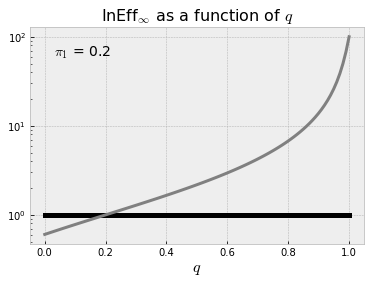

In [13]:
def relative_var(q, L=100):
    S = np.arange(1, L+1)
    K = transition_matrix(q)
    lam = np.linalg.eig(K)[0][0]
    return 1+2*np.dot((L-S)/L, lam**S)

q_vec = np.linspace(0+1e-13, 1.0-1e-13, 100)
rv = np.vectorize(relative_var)(q_vec)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(q_vec, np.ones_like(q_vec), color='Black', linewidth=5)
plt.plot(q_vec, rv, linewidth=3, color='grey')

plt.title(r'InEff$_\infty$ as a function of $q$',fontsize=16)
plt.xlabel(r'$q$', fontsize=16)
plt.text(0.03, 60, r'$\pi_1$ = {}'.format(pi1), fontsize=14)
ax.set_yscale('log')

For $q=\pi_1$ the inefficiency factor is one. For $q> \pi_1$ the inefficiency factor is greater
than one because the draws are positively correlated, whereas for $q< \pi_1$ the algorithm produces
negatively correlated draws which lead to an inefficiency factor that is less than one.

## Simulation Exercise

We want to from a numerical illustration, without relying on any asymptotic or analytic expressions.  What we'd like to do is assess for a given proposal distribution and chain length $N$, 1) if the MCMC algorithm converges in the sense that draws from the chain reflect draws from our posterior, and 2) how the different choices of $q$ affect the variance of estimates using these chains.  

To do this, we setup a simple function to run the MH algorithm.

In [14]:
from numpy.random import uniform

def MCMC(N, starting_theta, q=prop(pi1)):
    """
    runs an MH chain of length N using proposal q, 
    starting at starting_theta
    """
    parasim = np.zeros((N))
 
    parasim[0] = starting_theta

    for i in np.arange(1, N):
        t0 = parasim[i-1]
        t1 = q[t0].rvs()
 
        mh_ratio = ( tau.pmf(t1)/ q[t0].pmf(t1) ) / (tau.pmf(t0)/q[t1].pmf(t0))
    
        alp = np.min([1, mh_ratio])
 
        u = uniform()
 
        if u < alp:
            t0 = t1
 
        parasim[i] = t0
 
    return parasim


We can think about estimating $\bar V(\bar h)$, the variance associate with the Monte Carlo estimate $\bar h_N$. in two ways.

1. From a given chain,  we compute an estimate of $\Omega(h)/N$, using a simple
Newey-West heteroskedastic- and autocorrelation-consistent (HAC) estimator.

2. We can run many chains to obtain a set of $\{\bar h_N^j\}_{j=1}^{nsim}$, and
then compute the variance of this estimator, denoted by $\mathbb{V}[\bar{h}_N]$

If the chain is converged, so that the central limit theorem above holds, the
measures obtained by (1) and (2) should be more or less, as they are both
estimating the same object.  

Before we continue, we need to define a simple HAC estimator.

In [15]:
from statsmodels.tsa.stattools import acovf

def HAC(x, L=5000):
    "Very simple HAC estimator."
    K = 1 - np.arange(0, L+1)/(L+1)
    prod = np.ones_like(K)
    prod[1:] = 2
    gamma = acovf(x, fft=True)[0:L+1]
    return np.dot(K*prod, gamma)

In our simulation study, for each $q$ we'll run $10$ MH chains of length $N=1000$. 

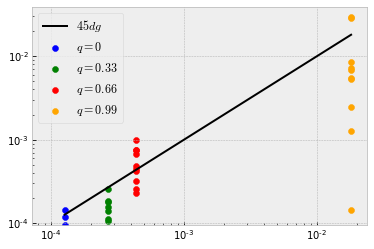

In [16]:
nsim = 10                       # number of MCMC runs 
N = 1000                        # length of chain
nburn = 0                       # burn in 
fig = plt.figure()
ax = fig.add_subplot(111)

ii = 0
means = np.zeros((4))
colors = ['Blue', 'Green', 'Red', 'Orange']
for q in np.linspace(0.000001, 0.99, 4):
     
    h = np.mean
    h_mcmc = np.zeros((nsim))
    h_hac = np.zeros((nsim))
    for i in np.arange(0, nsim):
        parasim= MCMC(N, 1, q=prop(q))
        parasim = parasim[nburn:]
        h_mcmc[i] = h(parasim)
        h_hac[i] = HAC(parasim, L=400)/N

    vmu = np.var(h_mcmc)
    means[ii] = vmu

    plt.scatter(np.ones_like(h_hac)*vmu, h_hac, color=colors[ii])
    ii += 1

    
#from scipy.stats.kde import gaussian_kde
plt.plot(means, means, color='Black')
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(['$45 dg$', r'$q=0$', '$q=0.33$', '$q=0.66$', '$q=0.99$'], fontsize=12, loc='upper left')


The $y$-coordinate of the dots represents the HAC
estimates for each $q$, while the $x$-coordinate indicates an estimate
of the small-sample variance $\mathbb{V}[\bar{h}_N]$ for each $q$.
The solid line gives the 45-degree line.  One can see that relative
ordering for the $q$-s is preserved in small samples, with $q = 0$
having the lowest small-sample variance and $q = 0.99$ having the
highest.  More importantly, the small-sample variance for each of the
simulators is bracketed by the HAC estimates, indicated by the solid
line bisecting the dots for each $q$.  That is, the within-chain
estimates appear consistent with the between-chain measures, though on
average the HAC estimator underestimates the variance of the Monte
Carlo approximation.